### Adjacency method for different variables and different thresholds

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import io
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageChops, ImageFont
import shapely.geometry as geom
from shapely.ops import unary_union
import warnings

import invr

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Creating the test dataset

In [4]:
# Create a DataFrame with box names and values
box_names = [chr(65 + i) for i in range(16)]
values = list(range(0, 16))
values_1 = [1,2,3,4,8,7,6,5,9,10,11,12,16,15,14,13]
values_3 = [1,5,3,16,14,2,15,4,7,13,8,9,12,10,11,6]
values_2 = list(range(1, 17))
df = pd.DataFrame({'FIPS': box_names, 'Value': values,'Value_1': values_1,'Value_2': values_2,'Value_3': values_3})

In [5]:
df

,FIPS,Value,Value_1,Value_2,Value_3
0,A,0,1,1,1
1,B,1,2,2,5
2,C,2,3,3,3
3,D,3,4,4,16
4,E,4,8,5,14
5,F,5,7,6,2
6,G,6,6,7,15
7,H,7,5,8,4
8,I,8,9,9,7
9,J,9,10,10,13


In [8]:
# Function to calculate square coordinates for a given name
def calculate_square_coordinates(row):
    box_name = row['FIPS']
    value = row['Value']
    # Assuming each smaller square has a side length of 1 unit
    x = value % 4
    y = value // 4
    # Return square coordinates as a Shapely polygon
    return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

In [9]:
# Calculate square coordinates for each row and create a geometry column
df['geometry'] = df.apply(calculate_square_coordinates, axis=1)

In [10]:
df

,FIPS,Value,Value_1,Value_2,Value_3,geometry
0,A,0,1,1,1,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"
1,B,1,2,2,5,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))"
2,C,2,3,3,3,"POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))"
3,D,3,4,4,16,"POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))"
4,E,4,8,5,14,"POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))"
5,F,5,7,6,2,"POLYGON ((1 1, 2 1, 2 2, 1 2, 1 1))"
6,G,6,6,7,15,"POLYGON ((2 1, 3 1, 3 2, 2 2, 2 1))"
7,H,7,5,8,4,"POLYGON ((3 1, 4 1, 4 2, 3 2, 3 1))"
8,I,8,9,9,7,"POLYGON ((0 2, 1 2, 1 3, 0 3, 0 2))"
9,J,9,10,10,13,"POLYGON ((1 2, 2 2, 2 3, 1 3, 1 2))"


Generate adjacent counties

In [19]:
def generate_adjacent_counties(dataframe,filtration_threshold,variable_name):
    filtered_df = dataframe[dataframe[variable_name] < filtration_threshold]

    # Perform a spatial join to find adjacent precincts
    adjacent_counties = gpd.sjoin(filtered_df, filtered_df, predicate='intersects', how='left')

    # Filter the results to include only the adjacent states
    adjacent_counties = adjacent_counties.query('sortedID_left != sortedID_right')

    # Group the resulting dataframe by the original precinct Name and create a list of adjacent precinct Name
    adjacent_counties = adjacent_counties.groupby('sortedID_left')['sortedID_right'].apply(list).reset_index()

    adjacent_counties.rename(columns={'sortedID_left': 'county', 'sortedID_right': 'adjacent'}, inplace=True)

    adjacencies_list = adjacent_counties['adjacent'].tolist()

    merged_df = pd.merge(adjacent_counties, dataframe, left_on='county',right_on='sortedID', how='left')
    merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry')

    return adjacencies_list,merged_df

In [20]:
def form_simplicial_complex(adjacent_county_list):
    max_dimension = 3

    V = []
    V = invr.incremental_vr(V, adjacent_county_list, max_dimension)

    return V
    

In [21]:
def fig2img(fig):
     #convert matplot fig to image and return it

     buf = io.BytesIO()
     fig.savefig(buf)
     buf.seek(0)
     img = Image.open(buf)
     return img

In [37]:
def plot_simplicial_complex(dataframe,V):

    #city centroids
    city_coordinates = {city.sortedID: np.array((city.geometry.centroid.x, city.geometry.centroid.y)) for _, city in dataframe.iterrows()}

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_axis_off() 

    # Plot the "wyoming_svi" DataFrame
    dataframe.plot(ax=ax, edgecolor='black', linewidth=0.3, color="white")

    # # Plot the centroid of the large square with values
    # for i, row in dataframe.iterrows():
    #     centroid = row['geometry'].centroid
    #     text_to_display = f"FIPS: {row['FIPS']}\nFilteration: {row['Value_2']}"
    #     # plt.text(centroid.x, centroid.y, str(row['FIPS']), fontsize=15, ha='center', color="black")
    #     plt.text(centroid.x, centroid.y, text_to_display, fontsize=15, ha='center', color="black")

    for edge_or_traingle in V:

        
        if len(edge_or_traingle) == 2:
            # Plot an edge
            ax.plot(*zip(*[city_coordinates[vertex] for vertex in edge_or_traingle]), color='red', linewidth=2)
            # img = fig2img(fig)
            # list_gif.append(img)
        elif len(edge_or_traingle) == 3:
            # Plot a triangle
            ax.add_patch(plt.Polygon([city_coordinates[vertex] for vertex in edge_or_traingle], color='green', alpha=0.2))
            # img = fig2img(fig)
            # list_gif.append(img)
    plt.show()
    plt.close()

    #return list_gif #deleted  plot_simplicial_complex(dataframe,V,list_gif) --> list part

##### Multiple variable code starts here

In [38]:
# define a dictionary wich has name and a value
selected_variables_and_threshold = {'Value_1': 7, 'Value_2':7, 'Value_3': 7}

In [39]:
# create a empty dictionary
edges_and_traingles_for_each_variable = {}

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_33752/3796410858.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_variable.sort_values(by=variable_name, inplace=True)
/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_33752/3796410858.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_variable['sortedID'] = range(len(df_one_variable))


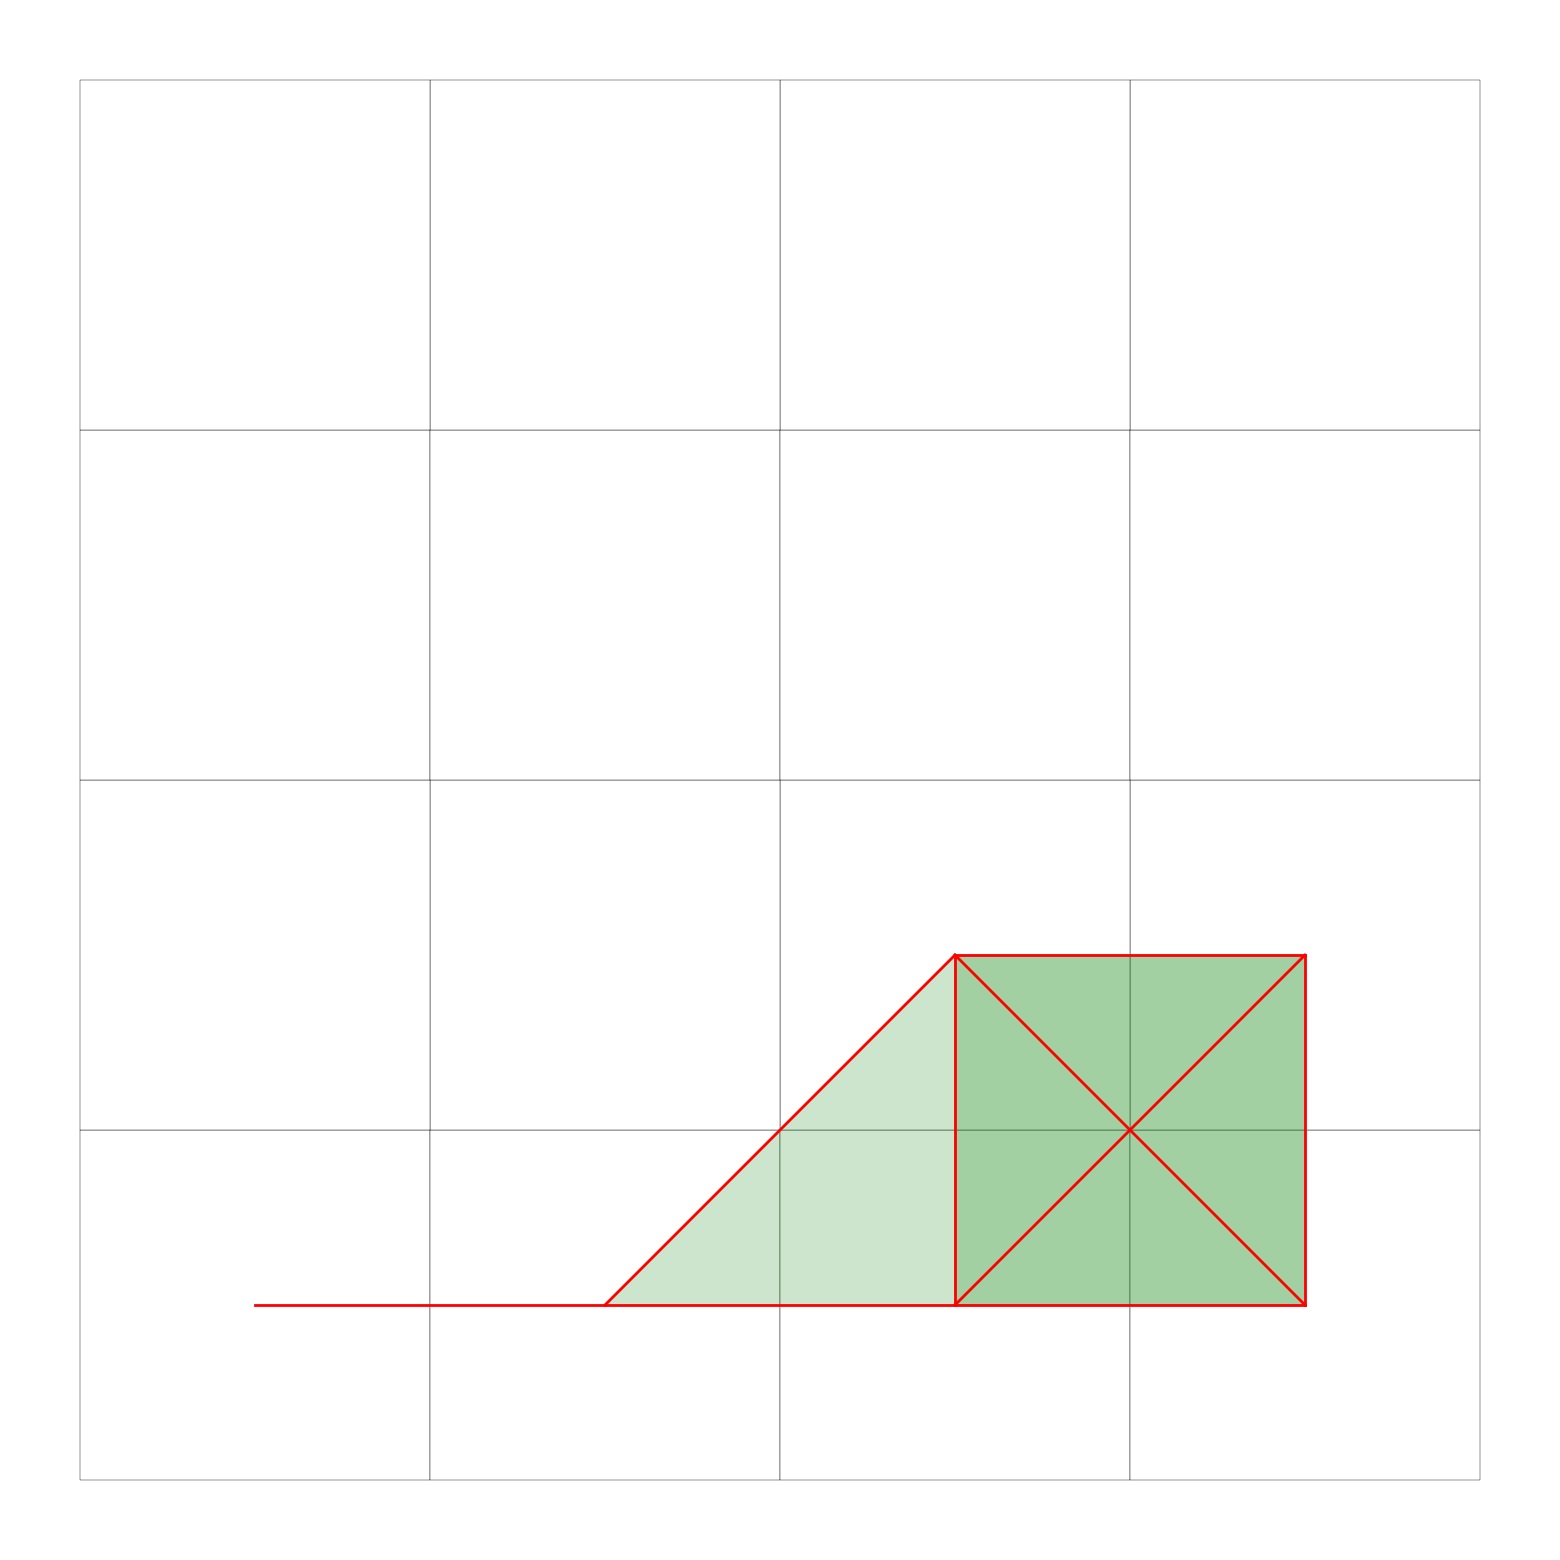

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_33752/3796410858.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_variable.sort_values(by=variable_name, inplace=True)
/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_33752/3796410858.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_variable['sortedID'] = range(len(df_one_variable))


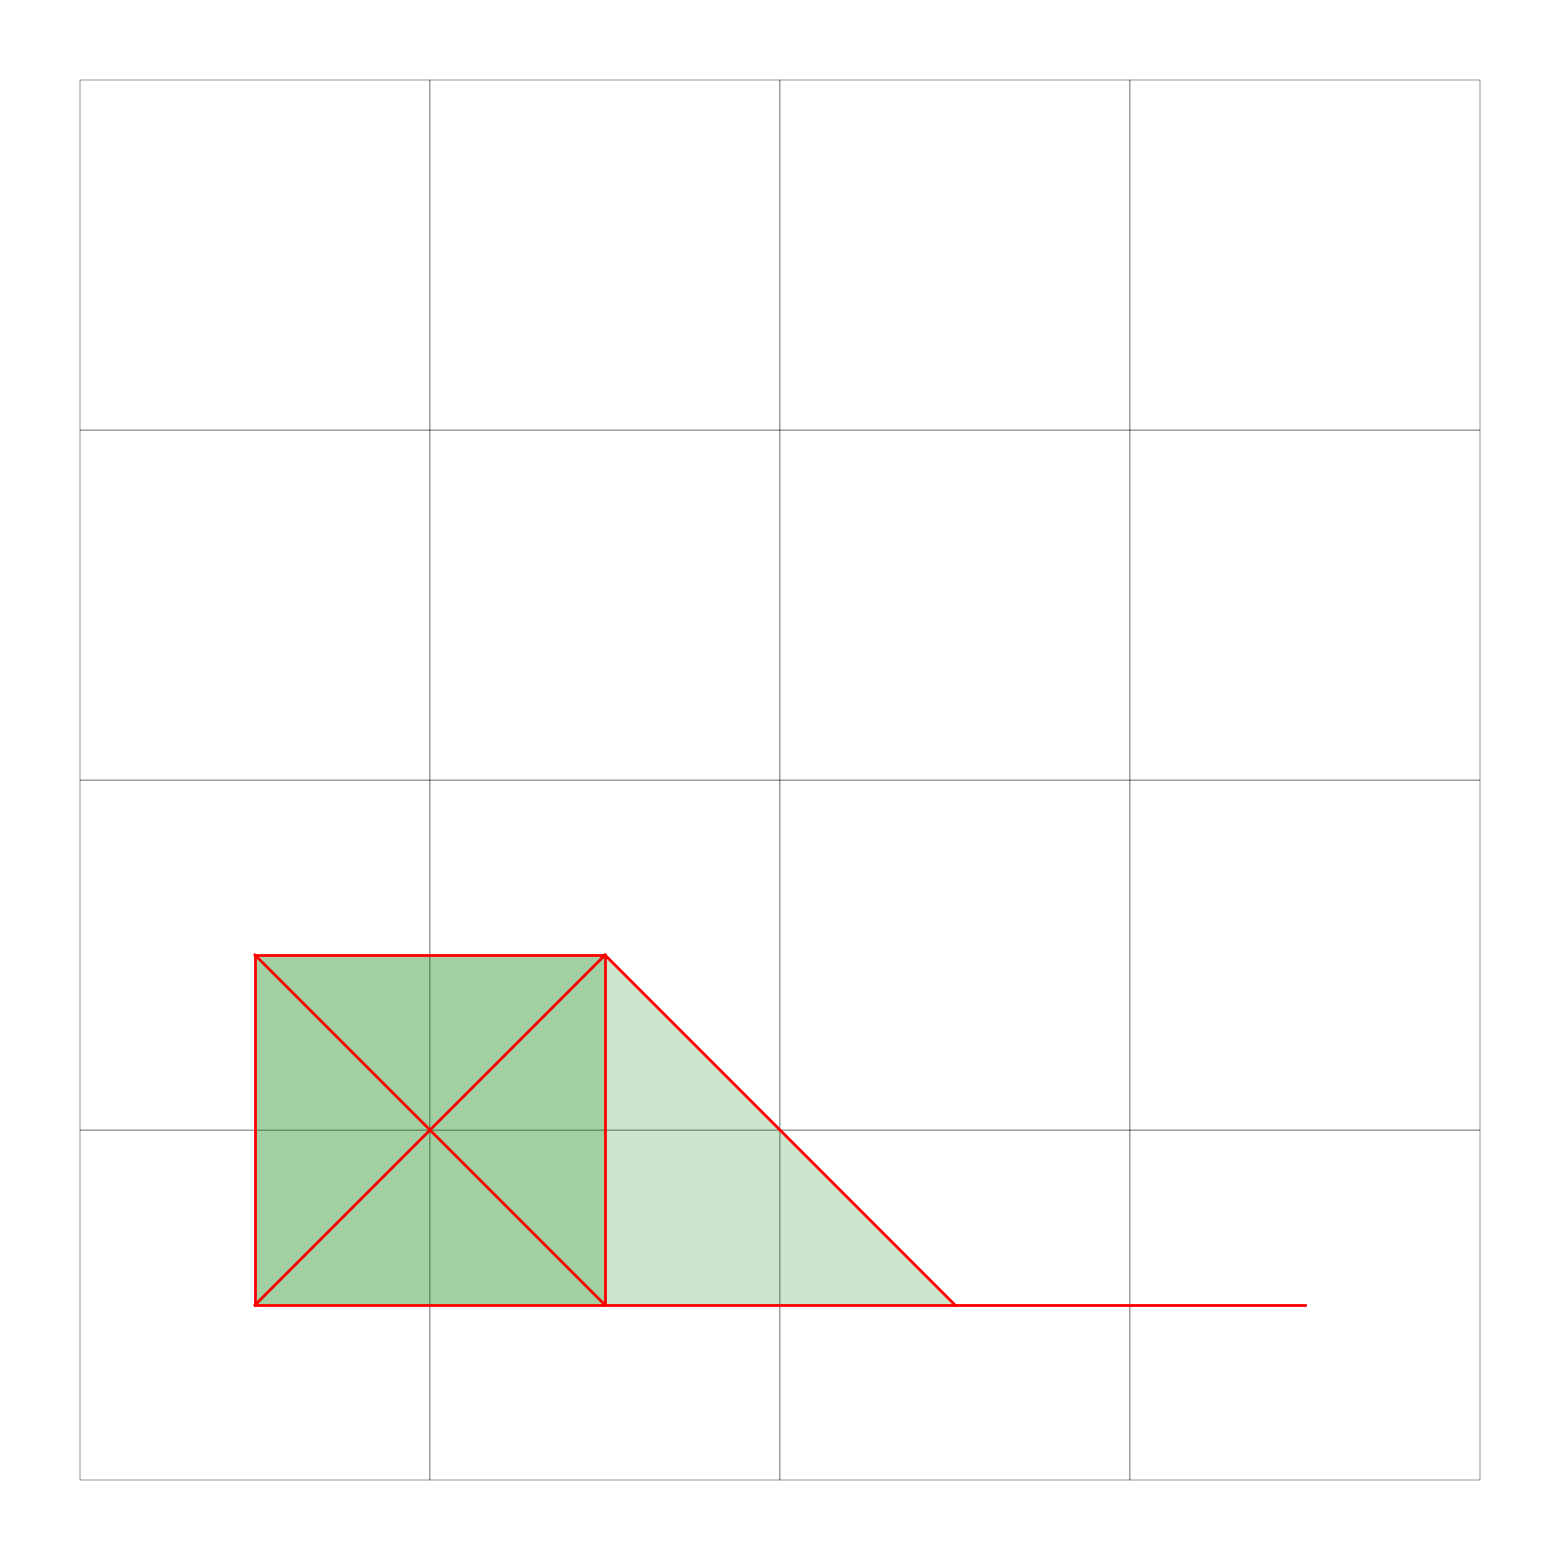

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_33752/3796410858.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_variable.sort_values(by=variable_name, inplace=True)
/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_33752/3796410858.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_variable['sortedID'] = range(len(df_one_variable))


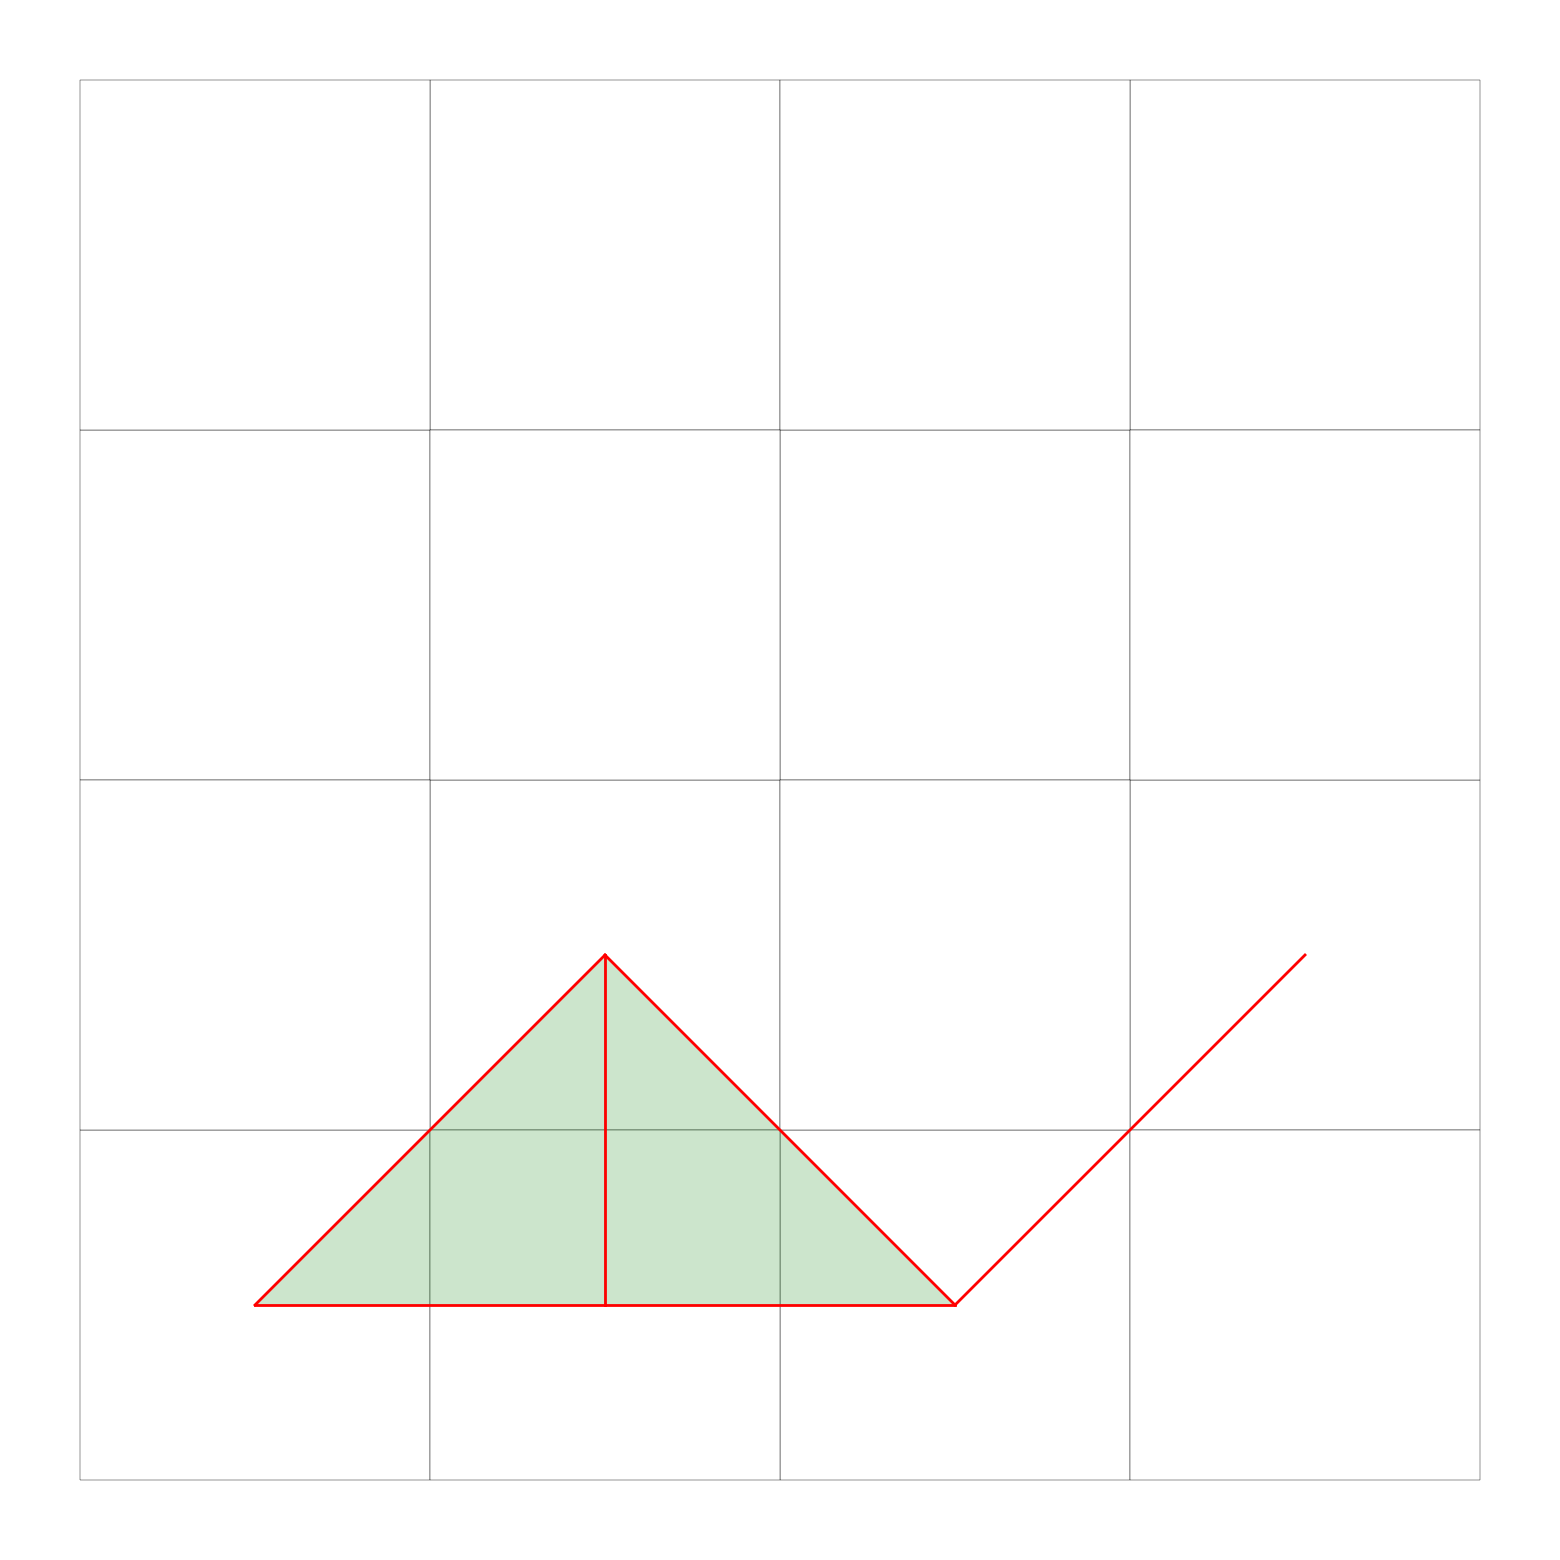

In [40]:
for variable_name, threshold in selected_variables_and_threshold.items():

    # Sorting based on the variable and selecting only the FIPS and the variable columns is important
    # Also we need to keep  the dataframe sorted based on the variable

    df_one_variable = df[['FIPS',variable_name, 'geometry']]

    # # Sorting the DataFrame based on the 'rate' column
    df_one_variable.sort_values(by=variable_name, inplace=True)
    df_one_variable['sortedID'] = range(len(df_one_variable))

    # Convert the DataFrame to a GeoDataFrame
    df_one_variable = gpd.GeoDataFrame(df_one_variable, geometry='geometry')
    df_one_variable.crs = "EPSG:3395"  # This is a commonly used projected CRS

    adjacencies_list,adjacent_counties_df = generate_adjacent_counties(df_one_variable,threshold,variable_name)
    V = form_simplicial_complex(adjacencies_list)

    # #add V list to the edges_and_traingles_for_each_variable dictionary with the key as the variable name
    edges_and_traingles_for_each_variable[variable_name] = V

    # # # store the list of images for each variable
    # # list_img = []

    # # plot the simplicial complex
    plot_simplicial_complex(df_one_variable,V)
